## Read Local Volume Galaxy Catalogue

In [10]:
import pandas as pd
import numpy as np
import re

# Column names
colnames = [
    "Name", "RAh", "RAm", "RAs", "DE_sign", "DEd", "DEm", "DEs",
    "a26", "b_a", "AB", "l_FUVmag", "FUVmag", "Bmag", "l_Hamag", 
    "Hamag", "Kmag", "f_Kmag", "l_21mag", "21mag", "W50", "TType",
    "Tdw1", "Tdw2", "RVel", "Dis", "f_Dis"
]

# Column byte ranges (0-indexed, end-exclusive)
colspecs = [
    (0,18), (19,21), (21,23), (23,27), (27,28), (28,30), (30,32), (32,34),
    (35,41), (42,46), (47,51), (52,53), (53,58), (59,64), (65,66),
    (66,71), (72,77), (77,78), (80,81), (81,86), (87,90), (91,93),
    (94,99), (100,101), (102,106), (107,112), (113,117)
]

# Step 1: Find first line of galaxy data
data_file = "../data/lvg_table1.dat"
galaxy_pattern = re.compile(r"\d{6}\.\d[+-]\d{6}")  # matches RA+Dec like 000021.4+310119
skip_lines = 0
with open(data_file) as f:
    for line in f:
        if galaxy_pattern.search(line):
            break
        skip_lines += 1

# Step 2: Read the fixed-width file
df = pd.read_fwf(
    data_file,
    colspecs=colspecs,
    names=colnames,
    skiprows=skip_lines,
    dtype=str
)

# Step 3: RA/Dec conversion functions
def ra_to_deg(h, m, s):
    try:
        return (float(h) + float(m)/60 + float(s)/3600) * 15
    except:
        return np.nan

def dec_to_deg(sign, d, m, s):
    try:
        deg = float(d) + float(m)/60 + float(s)/3600
        if sign.strip() == '-':
            deg *= -1
        return deg
    except:
        return np.nan

df["RA_deg"] = df.apply(lambda row: ra_to_deg(row["RAh"], row["RAm"], row["RAs"]), axis=1)
df["Dec_deg"] = df.apply(lambda row: dec_to_deg(row["DE_sign"], row["DEd"], row["DEm"], row["DEs"]), axis=1)

# Step 4: Convert numeric columns
num_cols = ["a26","b_a","AB","FUVmag","Bmag","Hamag","Kmag","21mag","W50","TType","RVel","Dis"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col].str.replace('>','').str.strip(), errors='coerce')

# Flags
flag_cols = ["l_FUVmag","l_Hamag","f_Kmag","l_21mag","Tdw1","Tdw2","f_Dis"]

# Quick check
print(df.head())
print(df[["RA_deg","Dec_deg"]].head())


        Name RAh RAm   RAs DE_sign DEd DEm DEs    a26   b_a  ...  21mag   W50  \
0  AGC102728  00  00  21.4       +  31  01  19   0.20  0.58  ...   18.7  21.0   
1   UGC12894  00  00  22.5       +  39  29  44   1.02  0.87  ...   15.7  34.0   
2  PGC000083  00  01  06.5       +  32  22  41   0.74  0.29  ...   17.0  32.0   
3        WLM  00  01  58.1       -  15  27  40  11.48  0.35  ...   11.2  53.0   
4  And XVIII  00  02  14.5       +  45  05  20   1.60  0.97  ...   14.8  23.0   

   TType  Tdw1 Tdw2   RVel    Dis f_Dis    RA_deg    Dec_deg  
0   10.0    Ir    L  566.0  12.42  TRGB  0.089167  31.021944  
1   10.0    Ir    L  335.0   9.05  TRGB  0.093750  39.495556  
2   10.0    Ir    L  542.0   9.29   BTF  0.277083  32.378056  
3    9.0    Im    N -122.0   0.98  TRGB  0.492083 -15.461111  
4   -3.0   Sph    L -332.0   1.31  TRGB  0.560417  45.088889  

[5 rows x 29 columns]
     RA_deg    Dec_deg
0  0.089167  31.021944
1  0.093750  39.495556
2  0.277083  32.378056
3  0.492083 -15.4611

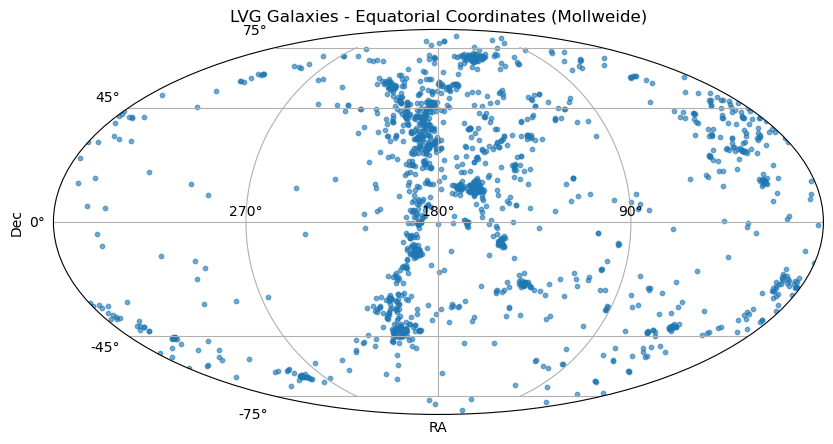

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Extract RA and Dec in degrees
ra = df["RA_deg"].values
dec = df["Dec_deg"].values

# Remove NaNs
mask = (~np.isnan(ra)) & (~np.isnan(dec))
ra = ra[mask]
dec = dec[mask]

# Convert RA from [0,360] to [-180,180] for Mollweide
# ra_wrap = ra.copy()
# ra_wrap[ra > 180] -= 360

# Convert to radians for Mollweide
ra_rad = np.radians(-ra + 180)  # Invert RA for correct orientation
dec_rad = np.radians(dec)

# Plot
plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection="mollweide")
ax.scatter(ra_rad, dec_rad, s=10, alpha=0.6)

xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.grid(True)
plt.title("LVG Galaxies - Equatorial Coordinates (Mollweide)")
plt.show()


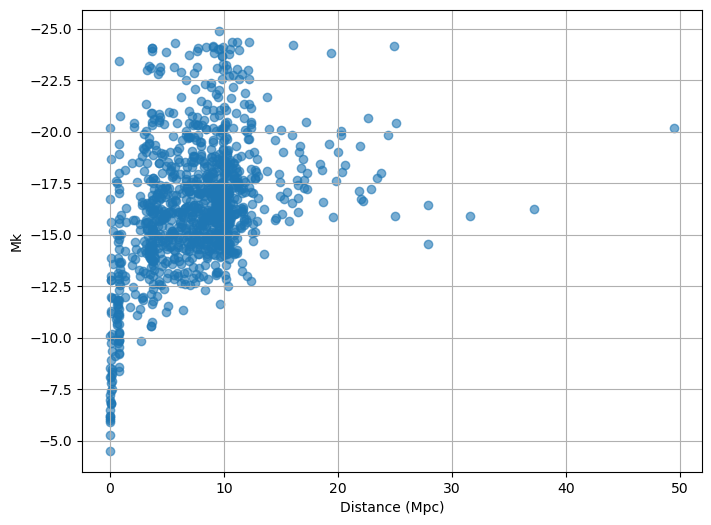

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Compute absolute K magnitude
df["M_K"] = df["Kmag"] - 5 * np.log10(df["Dis"]) - 25

# Mask valid entries
mask = (~df["M_K"].isna()) & (~df["RVel"].isna()) & (df["Dis"] > 0)
M_K = df.loc[mask, "M_K"]
RVel = df.loc[mask, "RVel"]
dist = df.loc[mask, "Dis"]

# 2D histogram
plt.figure(figsize=(8,6))
plt.grid()
plt.scatter(dist, M_K, alpha=.6)#, bins=50, cmap='Blues', norm=plt.matplotlib.colors.LogNorm())
#plt.colorbar(label='Number of Galaxies')
plt.ylabel('Mk')
plt.xlabel('Distance (Mpc)')
plt.gca().invert_yaxis()  # brighter = up
#plt.title('LVG: M_K vs RVel')
plt.show()


In [31]:
dist.min()

np.float64(0.02)